# 1. Set up the notebook

## 1.1 Import modules

In [2]:
import numpy as np
import sympy as sym
import json
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.interpolate import interp1d
from IPython.display import display, IFrame, HTML

## 1.2 Define data loaders

Here is a function to load data from simulation.

In [3]:
def load_simulation_data(filename, dronename):
    # load data for all drones
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # get data for one drone only
    data = data[dronename]
    
    # convert lists to numpy arrays
    for key in data.keys():
        if isinstance(data[key], dict):
            for subkey in data[key].keys():
                data[key][subkey] = np.array(data[key][subkey])
        else:
            data[key] = np.array(data[key])
    
    # return the data
    return data

Here is a function to load data from hardware (and resample it at 100 Hz using linear interpolation).

In [4]:
def load_hardware_data(filename, t_min_offset=0, t_max_offset=0):
    # load raw data
    with open(filename, 'r') as f:
        data = json.load(f)

    # convert lists to numpy arrays
    for val in data.values():
        for key in val.keys():
            val[key] = np.array(val[key])

    # create an array of times at which to subsample
    t_min = -np.inf
    t_max = np.inf
    for key, val in data.items():
        t_min = max(t_min, val['time'][0])
        t_max = min(t_max, val['time'][-1])
    t_min += t_min_offset * 1000
    t_max -= t_max_offset * 1000
    nt = int(1 + np.floor((t_max - t_min) / 10.))
    t = np.arange(0, 10 * nt, 10) / 1000.
    resampled_data = {'time': t}

    # resample raw data with linear interpolation
    for k, v in data.items():
        f = interp1d((v['time'] - t_min) / 1000., v['data'])
        resampled_data[k] = f(t)
        
    # return the resampled data
    return resampled_data

## 1.3 Define autoencoders

Here is a function to print code that implements linear state feedback.

In [5]:
def export_controller(K, s, i, s_with_des, i_eq,
                      decimals=8,
                      suffix='',
                      line_ending=''):
    """
    K is a gain matrix, of size m x n
    s is a list of states as symbolic variables, of length n
    i is a list of inputs as symbolic variables, of length m
    s_with_des is a list of states that have desired values, as
        symbolic variables - if there are no such states, then
        this should be an empty list []
    i_eq is a list of equilibrium values of inputs, of length m
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    s_name = [scur.name for scur in s]
    i_name = [icur.name for icur in i]
    for row in range(len(i_name)):
        input_string = ''
        for col in range(len(s_name)):
            k = K[row, col]
            if not np.isclose(k, 0.):
                if (k < 0) and input_string:
                    input_string += ' +'
                if s[col] in s_with_des:
                    n = f'({s_name[col]} - {s_name[col]}_des)'
                else:
                    n = s_name[col]
                input_string += f' {-k:.{decimals}f}{suffix} * {n}'
        if not np.isclose(i_eq[row], 0.):
            if (i_eq[row] > 0) and input_string:
                input_string += ' +'
            input_string += f' {i_eq[row]:.{decimals}f}{suffix}'
        print(f'{i_name[row]} ={input_string}{line_ending}')

Here is a function to print code that implements a method of power distribution.

In [6]:
def export_power_distribution(Pinv,
                              limiter='self.limitUint16',
                              decimals=1,
                              suffix='',
                              line_ending=''):
    """
    Pinv is a 4 x 4 matrix that maps inputs (tau_x, tau_y, tau_z, f_z)
        to motor power commands (m_1, m_2, m_3, m_4)
    limiter is the name of the function to apply that ensures each
        motor power command is valid (i.e., an integer within bounds),
        for example "limitUint16" when exporting to C
    decimals is the number of decimals to include when printing
        each value
    suffix is the character (if any) to print after each number,
        for example 'f' to indicate a "float" when exporting to C
    line_ending is the character (if any) to print after each
        line, for example ';' when exporting to C
    """
    
    i_name = ['tau_x', 'tau_y', 'tau_z', 'f_z']
    m_name = ['m_1', 'm_2', 'm_3', 'm_4']
    for row in range(len(m_name)):
        input_string = ''
        for col in range(len(i_name)):
            k = Pinv[row, col]
            if not np.isclose(k, 0.):
                if (k > 0) and input_string:
                    input_string += ' +'
                n = i_name[col]
                input_string += f' {k:.{decimals}f}{suffix} * {n}'
        print(f'{m_name[row]} = {limiter}({input_string} ){line_ending}')

## 1.5 Define an LQR solver

Here is a function that solves the linear quadratic regulator (LQR) problem - i.e., that finds the matrix $K$ for which

$$u(t) = - K x(t)$$

is the optimal solution to

$$
\begin{align*}
\underset{u_{[t_{0}, \infty)}}{\text{minimize}} &\qquad \int_{t_{0}}^{\infty}\left( x(t)^{T}Qx(t)+u(t)^{T}Ru(t)\right)dt \\
\text{subject to} &\qquad \dot{x}(t) = Ax(t)+Bu(t), \quad x(t_{0})=x_{0}.
\end{align*}
$$

In [7]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @  B.T @ P
    return K

## 1.6 Define a function to embed videos

Define a function to embed videos that have been uploaded to [Illinois Mediaspace](https://mediaspace.illinois.edu/).

In [8]:
def mediaspace(url, width=640, height=397):
    video_id = url.rsplit('/', 1)[-1]
    src = f'https://mediaspace.illinois.edu/embed/secure/iframe/entryId/{video_id}?st=0'
    display(IFrame(src, width=width, height=height))
    display(HTML(f'<a href="{url}" target="_blank">Go to video on Illinois Mediaspace</a>'))

# 2. Derive equations of motion

## 2.1 Define symbolic variables

Define states.

In [9]:
# components of position (meters)
o_x, o_y, o_z = sym.symbols('o_x, o_y, o_z')

# yaw, pitch, and roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')

Define inputs.

In [10]:
# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

Define parameters.

In [11]:
m, J_x, J_y, J_z, g = sym.symbols('m, J_x, J_y, J_z, g')

Create linear and angular velocity vectors (in coordinates of the body frame).

In [12]:
v_01in1 = sym.Matrix([v_x, v_y, v_z])
w_01in1 = sym.Matrix([w_x, w_y, w_z])

Create moment of inertia matrix (in coordinates of the body frame).

In [13]:
J_in1 = sym.diag(J_x, J_y, J_z)

## 2.2 Define kinematics of orientation

### 2.2.1 Rotation matrix in terms of yaw, pitch, roll angles

Define individual rotation matrices.

In [14]:
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi), sym.cos(psi), 0],
                 [0, 0, 1]])

Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)],
                 [0, 1, 0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])

Rx = sym.Matrix([[1, 0, 0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi), sym.cos(phi)]])

Apply sequential transformation to compute the rotation matrix that describes the orientation of the drone (i.e., of frame 1 in the coordinates of frame 0).

In [15]:
R_1in0 = Rz * Ry * Rx

In [16]:
R_1in0

Matrix([
[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi),  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)],
[sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)],
[        -sin(theta),                              sin(phi)*cos(theta),                               cos(phi)*cos(theta)]])

### 2.2.2 Map from angular velocity to angular rates

Recall that

$$\begin{bmatrix} \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \end{bmatrix} = N w_{0, 1}^{1}$$

for some matrix $N$. Here is how to compute that matrix for a ZYX (yaw, pitch, roll) Euler angle sequence.  First, we compute its inverse:

In [17]:
Ninv = sym.Matrix.hstack((Ry * Rx).T * sym.Matrix([0, 0, 1]),
                              (Rx).T * sym.Matrix([0, 1, 0]),
                                       sym.Matrix([1, 0, 0]))

Then, we compute $N$ by taking the inverse of $N^{-1}$:

In [18]:
N = sym.simplify(Ninv.inv())

In [19]:
N

Matrix([
[0, sin(phi)/cos(theta), cos(phi)/cos(theta)],
[0,            cos(phi),           -sin(phi)],
[1, sin(phi)*tan(theta), cos(phi)*tan(theta)]])

## 2.3 Define equations of motion

Forces.

In [20]:
f_in1 = R_1in0.T * sym.Matrix([0, 0, -m * g]) + sym.Matrix([0, 0, f_z])

Torques.

In [21]:
tau_in1 = sym.Matrix([tau_x, tau_y, tau_z])

In [22]:
f_in1

Matrix([
[               g*m*sin(theta)],
[     -g*m*sin(phi)*cos(theta)],
[f_z - g*m*cos(phi)*cos(theta)]])

In [23]:
tau_in1

Matrix([
[tau_x],
[tau_y],
[tau_z]])

Create equations of motion.

In [24]:
f_sym = sym.Matrix.vstack(R_1in0 * v_01in1,
                          N * w_01in1,
                          (1 / m) * (f_in1 - w_01in1.cross(m * v_01in1)),
                          J_in1.inv() * (tau_in1 - w_01in1.cross(J_in1 * w_01in1)))

Show equations of motion, which have the form

$$\dot{s} = f(s, i, p)$$

for states

$$
s = \begin{bmatrix} o_x \\ o_y \\ o_z \\ \psi \\ \theta \\ \phi \\ v_x \\ v_y \\ v_z \\ w_x \\ w_y \\ w_z \end{bmatrix},
$$

inputs
$$
i = \begin{bmatrix} \tau_x \\ \tau_y \\ \tau_z \\ f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m \\ J_x \\ J_y \\ J_z \\ g \end{bmatrix}.
$$

In [25]:
f_sym

Matrix([
[ v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) + v_z*(-sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi))],
[                                                                       -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                         w_y*sin(phi)/cos(theta) + w_z*cos(phi)/cos(theta)],
[                                                                                                               w_y*cos(phi) - w_z*sin(phi)],
[                                                                                   w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                (g*m*sin(theta) + m*v_y*w_z - m*v_z*w_y)/m

# 3. Derive state-space model

## 3.1 Choose equilibrium point

An equilibrium point of the nonlinear system is a choice of states $s_\text{eq}$ and inputs $i_\text{eq}$ - along with constant parameters $p_\text{eq}$ - for which

$$0 = f(s_\text{eq}, i_\text{eq}, p_\text{eq}).$$

Create a list of states, inputs, and parameters as symbolic variables.

In [26]:
s = [o_x, o_y, o_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]
i = [tau_x, tau_y, tau_z, f_z]
p = [m, J_x, J_y, J_z, g]

Create a list of states to track as symbolic variables. These are states whose desired values will be specified by a client.

In [27]:
s_with_des = [o_x, o_y, o_z]

Create a function that evaluates $f(\cdot)$ at particular values of $s$, $i$, and $p$.

In [28]:
f = sym.lambdify(s + i + p, f_sym)

Define constants.

In [29]:
# Mass
m = 0.0312    # <-- FIXME

# Principle moments of inertia
J_x = 1.3854992554639881e-05 # <-- FIXME
J_y = 1.3854992554639881e-05  # <-- FIXME
J_z = 2.8158758022122814e-05  # <-- FIXME

# Acceleration of gravity
g = 9.81

Create a list of parameter values in the **same order** as the symbolic list. These are the parameter estimates we found in our experiments. They are not choices. (We use the subscript `_eq` to be consistent with what follows, and could say "parameter values *at equilibrium*," but don't be misled. These parameter values are *given* and are *constant* - again, they aren't choices.)

In [30]:
p_eq = [m, J_x, J_y, J_z, g]

Create a list of state and input values at equilibrium in the **same order** as the symbolic lists.

In [31]:
s_eq = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.] # <-- FIXME
i_eq = [0., 0., 0., m * g]                                 # <-- FIXME

Evaluate the equations of motion at the equilibrium point - if it actually *is* an equilibrium point, then the result should be an array of zeros:

In [32]:
print(f(*s_eq, *i_eq, *p_eq))

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Note that this equilibrium point would remain an equilibrium point for any choice of `o_x`, `o_y`, and `o_z` - that is one thing that allows the controller to track desired values of these variables.

## 3.2 Compute A and B

We want to find

$$
A = \frac{\partial f}{\partial s}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}
\qquad\text{and}\qquad
B = \frac{\partial f}{\partial i}\biggr\vert_{(s, i, p) = (s_\text{eq}, i_\text{eq}, p_\text{eq})}.
$$

First, we compute each Jacobian (i.e., each matrix of partial derivatives) in symbolic form.

In [33]:
A_sym = f_sym.jacobian(s)
B_sym = f_sym.jacobian(i)

Then, we create functions that allow us to evaluate these Jacobians at particular values of $s$, $i$, and $p$.

In [34]:
A_num = sym.lambdify(s + i + p, A_sym)
B_num = sym.lambdify(s + i + p, B_sym)

Finally, we plug in our equilibrium point.

In [35]:
A = A_num(*s_eq, *i_eq, *p_eq)
B = B_num(*s_eq, *i_eq, *p_eq)

Show $A$ (formatted nicely).

In [36]:
A_str = np.array2string(A,
                        formatter={'float_kind': lambda x: f'{x:5.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'A = {A_str}')

A = [[ 0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  1.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00]
     [ 0.00  0.00  0.00  0.00  0.00 -0.00  0.00  0.00  0.00  0.00  1.00 -0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  1.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  9.81  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00 -9.81 -0.00  0.00  0.00  0.00  0.00 -0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00 -0.00  0.00 -0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
     [ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]]


Show $B$ (formatted nicely).

In [37]:
B_str = np.array2string(B,
                        formatter={'float_kind': lambda x: f'{x:10.2f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'B = {B_str}')

B = [[      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00       0.00]
     [      0.00       0.00       0.00      32.05]
     [  72176.15       0.00       0.00       0.00]
     [      0.00   72176.15       0.00       0.00]
     [      0.00       0.00   35512.93       0.00]]


The state-space system is described by

$$ \dot{x} = Ax + Bu $$

where

$$ x = s - s_\text{eq} $$

and

$$ u = i - i_\text{eq}. $$

Note that $A$ and $B$ would remain the same for any choice of `o_x`, `o_y`, and `o_z` - that is the other thing that allows the controller to track desired values of these variables.

# 4. Design method of power distribution

It should only be necessary to do this once.

Define constants.

In [38]:
k_F = 2.03e-06 # <-- FIXME
k_M = 9.04e-09 # <-- FIXME
l = 0.034  # <-- FIXME

Define the matrix $P$ that maps motor power commands ($m_1$, $m_2$, $m_3$, $m_4$) to inputs ($\tau_x$, $\tau_y$, $\tau_z$, $f_z$).

In [39]:
P = np.array([[ -l * k_F, -l * k_F,  l * k_F,  l * k_F  ],
              [ -l * k_F, l * k_F,   l * k_F,  -l * k_F ],
              [ -k_M,     k_M,       -k_M,     k_M      ],
              [ k_F,      k_F,       k_F,      k_F      ]])

Compute the matrix $P^{-1}$ that maps inputs to motor power commands.

In [40]:
Pinv = linalg.inv(P)

Print code that implements the method of power distribution in python (for simulation).

In [41]:
export_power_distribution(Pinv)

m_1 = self.limitUint16( -3622138.5 * tau_x -3622138.5 * tau_y -27654867.3 * tau_z + 123152.7 * f_z )
m_2 = self.limitUint16( -3622138.5 * tau_x + 3622138.5 * tau_y + 27654867.3 * tau_z + 123152.7 * f_z )
m_3 = self.limitUint16( 3622138.5 * tau_x + 3622138.5 * tau_y -27654867.3 * tau_z + 123152.7 * f_z )
m_4 = self.limitUint16( 3622138.5 * tau_x -3622138.5 * tau_y + 27654867.3 * tau_z + 123152.7 * f_z )


Print code that implements the method of power distribution in C (for hardware).

In [42]:
export_power_distribution(
    Pinv,
    limiter='limitUint16',
    suffix='f',
    line_ending=';',
)

m_1 = limitUint16( -3622138.5f * tau_x -3622138.5f * tau_y -27654867.3f * tau_z + 123152.7f * f_z );
m_2 = limitUint16( -3622138.5f * tau_x + 3622138.5f * tau_y + 27654867.3f * tau_z + 123152.7f * f_z );
m_3 = limitUint16( 3622138.5f * tau_x + 3622138.5f * tau_y -27654867.3f * tau_z + 123152.7f * f_z );
m_4 = limitUint16( 3622138.5f * tau_x -3622138.5f * tau_y + 27654867.3f * tau_z + 123152.7f * f_z );


# 5. Design, implement, and test a sequence of controllers

To get a working controller in hardware, you will likely need to repeat the following steps many times:

* Design a controller
* Implement and test this controller in simulation
* Implement and test this controller in hardware

Here is a template for these three steps. Please duplicate this template for each flight test. Please also modify this template as appropriate (e.g., doing more than one flight test with the same controller, or doing only hardware flight tests when fine-tuning performance after you get a working controller).

## 5.x Flight test (template)

Each time you duplicate this section, replace the title with a brief description of your current flight test.

### 5.x.1 Control design

For your controller, we suggest you use linear state feedback of the form

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{x, \text{des}} \\ o_{y, \text{des}} \\ o_{z, \text{des}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}.$$

Remember that the LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices, $Q$ must be positive semidefinite, and $R$ must be positive definite. Both $Q$ and $R$ are almost always chosen to be diagonal. Remember that $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$). If you want smaller states, increase $Q$. If you want smaller inputs, increase $R$.

**Replace this text** to say why and how you chose $Q$ and $R$ for the controller used in this flight test.

In [ ]:
Q = np.diag([
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

R = np.diag([
    1.,
    1.,
    1.,
    1.,
])

Find $K$ for the chosen $Q$ and $R$.

In [ ]:
K = lqr(A, B, Q, R)

Show $K$ (formatted nicely).

In [ ]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

Print code that implements the controller in python (for simulation).

In [ ]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
)

Print code that implements the controller in C (for hardware).

In [ ]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

### 5.x.2 Simulation results

#### Describe the flight test

Replace this cell with the following information, at minimum:

* The name of the client you used (e.g., `RobotClient_Hover`).
* A description in words of the trajectory specified by this client.
* The initial state (i.e., as specified by `simulator.set_state`).

It may also be helpful to include a snippet of code from your client. You can include code in markdown with a "code block" that is delimited by three backslashes above and below - for example, this...

``````
```python
o_x = 0.
o_y = 0.
o_z = 0.3
psi = 0.
```
``````
...is rendered like this:
```python
o_x = 0.
o_y = 0.
o_z = 0.3
psi = 0.
```

#### Show a video of the flight test

In the following cell, show a video of your simulation flight test (change the url as appropriate).

In [ ]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

#### Plot results from the flight test

Load data from simulation.

In [ ]:
data = load_simulation_data(
    'simulation_x_data.json', # <-- replace with name of file with simulation data
    'my_drone',               # <-- replace with name of drone whose data you want to load
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [ ]:
# time
t = data['t']

# position
o_x = data['state']['o_x']
o_y = data['state']['o_y']
o_z = data['state']['o_z']

# desired position
o_x_des = data['setpoint']['o_x']
o_y_des = data['setpoint']['o_y']
o_z_des = data['setpoint']['o_z']

# orientation
psi = data['state']['psi']
theta = data['state']['theta']
phi = data['state']['phi']

# motor power commands
m_1 = data['power']['m_1']
m_2 = data['power']['m_2']
m_3 = data['power']['m_3']
m_4 = data['power']['m_4']

Compute error in position (this is a function of time).

In [ ]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

In [ ]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

#### Discuss the flight test

Replace this cell with a description of your results. Note any differences between what you expected and what you saw, in particular trying to explain the cause of any failures (e.g., crashed drone). Say what might be done to further improve performance.

### 5.x.3 Hardware results

#### Describe the flight test

Replace this cell with the following information, at minimum:

* A description of the flight trajectory, both in words and (if you like) a snippet of code from `flight.py`.
* A description of the flight conditions (e.g., where was the flight conducted, did you power cycle the drone just before flying, were you using the positioning system or only the onboard sensors, etc.).

#### Show a video of the flight test

In the following cell, show a video of your hardware flight test (change the url as appropriate).

In [ ]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

#### Plot results from the flight test

Load data from hardware.

In [ ]:
data = load_hardware_data(
    'hardware_x_data.json', # <-- replace with name of file with hardware data
    t_min_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at end
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [ ]:
# time
t = data['time']

# position
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# orientation
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']

# motor power commands
m_1 = data['ae483log.m_1']
m_2 = data['ae483log.m_2']
m_3 = data['ae483log.m_3']
m_4 = data['ae483log.m_4']

Compute error in position (this is a function of time).

In [ ]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

In [ ]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

#### Discuss the flight test

Replace this cell with a description of your results. Note any differences between what you expected and what you saw, in particular trying to explain the cause of any failures (e.g., crashed drone). Say what might be done to further improve performance.

# 5. Design, implement, and test a sequence of controllers

To get a working controller in hardware, you will likely need to repeat the following steps many times:

* Design a controller
* Implement and test this controller in simulation
* Implement and test this controller in hardware

Here is a template for these three steps. Please duplicate this template for each flight test. Please also modify this template as appropriate (e.g., doing more than one flight test with the same controller, or doing only hardware flight tests when fine-tuning performance after you get a working controller).

## 5.1 Flight test

Each time you duplicate this section, replace the title with a brief description of your current flight test.

### 5.1.1 Control design

For your controller, we suggest you use linear state feedback of the form

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{x, \text{des}} \\ o_{y, \text{des}} \\ o_{z, \text{des}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}.$$

Remember that the LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices, $Q$ must be positive semidefinite, and $R$ must be positive definite. Both $Q$ and $R$ are almost always chosen to be diagonal. Remember that $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$). If you want smaller states, increase $Q$. If you want smaller inputs, increase $R$.

**Replace this text** to say why and how you chose $Q$ and $R$ for the controller used in this flight test.

In [42]:
Q = np.diag([
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

R = np.diag([
    1.,
    1.,
    1.,
    1.,
])

Find $K$ for the chosen $Q$ and $R$.

In [43]:
K = lqr(A, B, Q, R)

Show $K$ (formatted nicely).

In [44]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[-0.000 -1.000 -0.000 -0.000 -0.000  5.430 -0.000 -1.452 -0.000  1.000 -0.000  0.000]
     [ 1.000 -0.000 -0.000 -0.000  5.430  0.000  1.452 -0.000 -0.000 -0.000  1.000  0.000]
     [ 0.000  0.000 -0.000  1.000  0.000 -0.000  0.000  0.000 -0.000  0.000  0.000  1.000]
     [ 0.000 -0.000  1.000  0.000 -0.000  0.000  0.000 -0.000  1.031 -0.000 -0.000 -0.000]]


Print code that implements the controller in python (for simulation).

In [45]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
)

tau_x = 1.00000000 * (o_y - o_y_des) -5.42964420 * phi + 1.45153750 * v_y -1.00007522 * w_x
tau_y = -1.00000000 * (o_x - o_x_des) -5.42964420 * theta -1.45153750 * v_x -1.00007522 * w_y
tau_z = -1.00000000 * psi -1.00002816 * w_z
f_z = -1.00000000 * (o_z - o_z_des) -1.03072790 * v_z + 0.30607200


Print code that implements the controller in C (for hardware).

In [46]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

tau_x = 1.00000000f * (o_y - o_y_des) -5.42964420f * phi + 1.45153750f * v_y -1.00007522f * w_x;
tau_y = -1.00000000f * (o_x - o_x_des) -5.42964420f * theta -1.45153750f * v_x -1.00007522f * w_y;
tau_z = -1.00000000f * psi -1.00002816f * w_z;
f_z = -1.00000000f * (o_z - o_z_des) -1.03072790f * v_z + 0.30607200f;


### 5.1.2 Simulation results

#### Describe the flight test

Replace this cell with the following information, at minimum:

* The name of the client you used (e.g., `RobotClient_Hover`).
* A description in words of the trajectory specified by this client.
* The initial state (i.e., as specified by `simulator.set_state`).

It may also be helpful to include a snippet of code from your client. You can include code in markdown with a "code block" that is delimited by three backslashes above and below - for example, this...

``````
```python
o_x = 0.
o_y = 0.
o_z = 0.3
psi = 0.
```
``````
...is rendered like this:
```python
o_x = 0.
o_y = 0.
o_z = 0.3
psi = 0.
```

#### Show a video of the flight test

In the following cell, show a video of your simulation flight test (change the url as appropriate).

In [76]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/YOUR_VIDEO_ID')

#### Plot results from the flight test

Load data from simulation.

In [ ]:
data = load_simulation_data(
    'simulation_x_data.json', # <-- replace with name of file with simulation data
    'my_drone',               # <-- replace with name of drone whose data you want to load
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [ ]:
# time
t = data['t']

# position
o_x = data['state']['o_x']
o_y = data['state']['o_y']
o_z = data['state']['o_z']

# desired position
o_x_des = data['setpoint']['o_x']
o_y_des = data['setpoint']['o_y']
o_z_des = data['setpoint']['o_z']

# orientation
psi = data['state']['psi']
theta = data['state']['theta']
phi = data['state']['phi']

# motor power commands
m_1 = data['power']['m_1']
m_2 = data['power']['m_2']
m_3 = data['power']['m_3']
m_4 = data['power']['m_4']

Compute error in position (this is a function of time).

In [ ]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

In [ ]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

#### Discuss the flight test

Replace this cell with a description of your results. Note any differences between what you expected and what you saw, in particular trying to explain the cause of any failures (e.g., crashed drone). Say what might be done to further improve performance.

### 5.1.3 Hardware results

#### Describe the flight test

Replace this cell with the following information, at minimum:

* A description of the flight trajectory, both in words and (if you like) a snippet of code from `flight.py`.
* A description of the flight conditions (e.g., where was the flight conducted, did you power cycle the drone just before flying, were you using the positioning system or only the onboard sensors, etc.).

#### Show a video of the flight test

In the following cell, show a video of your hardware flight test (change the url as appropriate).

In [77]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/1_0fa6brdw')

#### Plot results from the flight test

Load data from hardware.

In [47]:
data = load_hardware_data(
    'hardware_1_data.json', # <-- replace with name of file with hardware data
    t_min_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at end
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [48]:
# time
t = data['time']

# position
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# orientation
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']

# motor power commands
m_1 = data['ae483log.m_1']
m_2 = data['ae483log.m_2']
m_3 = data['ae483log.m_3']
m_4 = data['ae483log.m_4']

Compute error in position (this is a function of time).

In [49]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

Text(0.5, 0, 'time (s)')

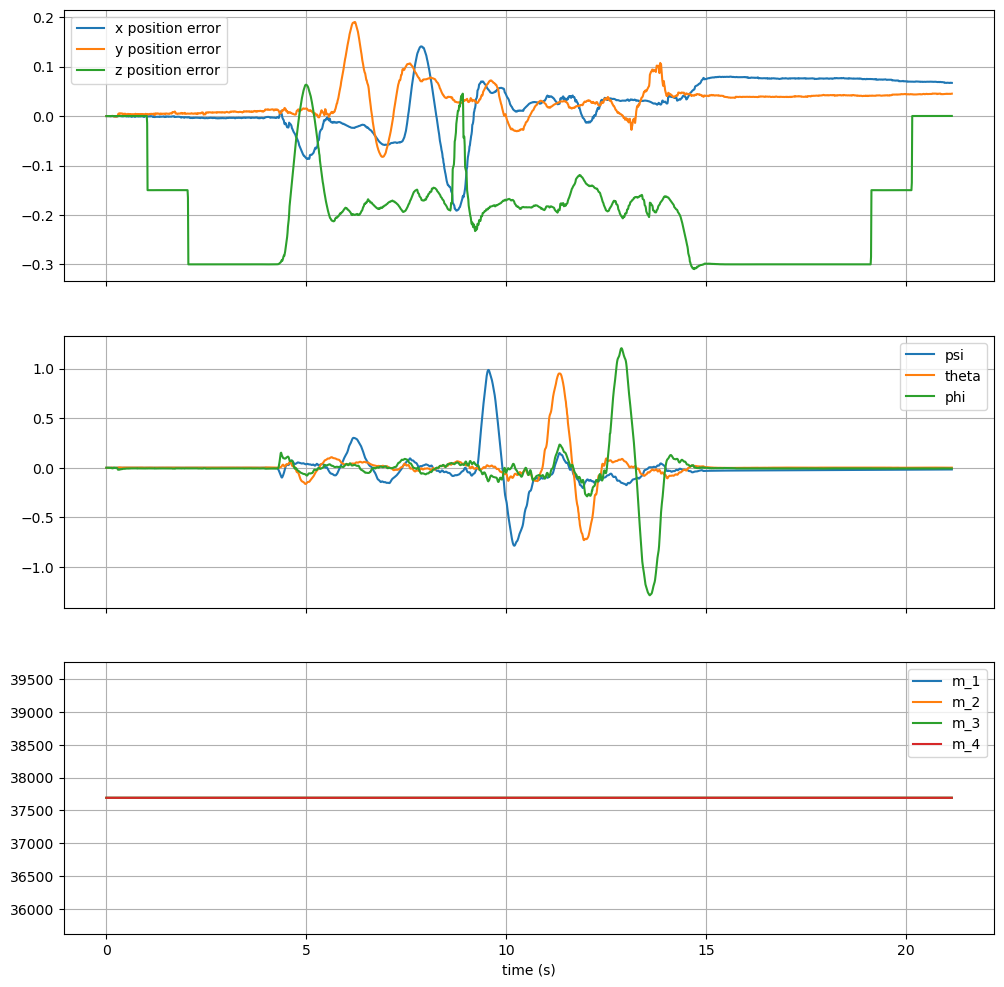

In [50]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

#### Discuss the flight test

Replace this cell with a description of your results. Note any differences between what you expected and what you saw, in particular trying to explain the cause of any failures (e.g., crashed drone). Say what might be done to further improve performance.

# 5. Design, implement, and test a sequence of controllers

To get a working controller in hardware, you will likely need to repeat the following steps many times:

* Design a controller
* Implement and test this controller in simulation
* Implement and test this controller in hardware

Here is a template for these three steps. Please duplicate this template for each flight test. Please also modify this template as appropriate (e.g., doing more than one flight test with the same controller, or doing only hardware flight tests when fine-tuning performance after you get a working controller).

## 5.2 Flight test

Each time you duplicate this section, replace the title with a brief description of your current flight test.

### 5.2.1 Control design

For your controller, we suggest you use linear state feedback of the form

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{x, \text{des}} \\ o_{y, \text{des}} \\ o_{z, \text{des}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}.$$

Remember that the LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices, $Q$ must be positive semidefinite, and $R$ must be positive definite. Both $Q$ and $R$ are almost always chosen to be diagonal. Remember that $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$). If you want smaller states, increase $Q$. If you want smaller inputs, increase $R$.

**Replace this text** to say why and how you chose $Q$ and $R$ for the controller used in this flight test.

In [51]:
Q = np.diag([
    10.,
    10.,
    100.,
    10.,
    10.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

R = 10 * np.diag([
    (1/(4*l*k_F * 6960.5))**2,
    (1/(4*l*k_F * 6960.5))**2,
    (1/(4*k_M * 6960.5))**2,
    (1/(4*k_F * 6960.5))**2,
])

Find $K$ for the chosen $Q$ and $R$.

In [52]:
K = lqr(A, B, Q, R)

Show $K$ (formatted nicely).

In [53]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[ 0.000 -0.002  0.000  0.000  0.000  0.004  0.000 -0.001  0.000  0.001  0.000  0.000]
     [ 0.002 -0.000 -0.000  0.000  0.005  0.000  0.002 -0.000 -0.000  0.000  0.001  0.000]
     [-0.000  0.000  0.000  0.000 -0.000 -0.000 -0.000  0.000  0.000  0.000  0.000  0.000]
     [-0.000 -0.000  0.179  0.000 -0.000  0.000 -0.000 -0.000  0.107  0.000 -0.000  0.000]]


Print code that implements the controller in python (for simulation).

In [54]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
)

tau_x = 0.00192165 * (o_y - o_y_des) -0.00445915 * phi + 0.00145474 * v_y -0.00070202 * w_x
tau_y = -0.00192165 * (o_x - o_x_des) -0.00493433 * theta -0.00151737 * v_x -0.00071134 * w_y
tau_z = -0.00025169 * psi -0.00014321 * w_z
f_z = -0.17872959 * (o_z - o_z_des) -0.10710821 * v_z + 0.30607200


Print code that implements the controller in C (for hardware).

In [55]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

tau_x = 0.00192165f * (o_y - o_y_des) -0.00445915f * phi + 0.00145474f * v_y -0.00070202f * w_x;
tau_y = -0.00192165f * (o_x - o_x_des) -0.00493433f * theta -0.00151737f * v_x -0.00071134f * w_y;
tau_z = -0.00025169f * psi -0.00014321f * w_z;
f_z = -0.17872959f * (o_z - o_z_des) -0.10710821f * v_z + 0.30607200f;


### 5.2.2 Simulation results

#### Describe the flight test

Replace this cell with the following information, at minimum:

* The name of the client you used (e.g., `RobotClient_Hover`).
* A description in words of the trajectory specified by this client.
* The initial state (i.e., as specified by `simulator.set_state`).

It may also be helpful to include a snippet of code from your client. You can include code in markdown with a "code block" that is delimited by three backslashes above and below - for example, this...

``````
```python
o_x = 0.
o_y = 0.
o_z = 0.3
psi = 0.
```
``````
...is rendered like this:
```python
o_x = 0.
o_y = 0.
o_z = 0.3
psi = 0.
```

#### Show a video of the flight test

In the following cell, show a video of your simulation flight test (change the url as appropriate).

In [56]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/1_iraqcjt9')

#### Plot results from the flight test

Load data from simulation.

In [59]:
data = load_simulation_data(
    'simulation_2_data.json', # <-- replace with name of file with simulation data
    'my_drone',               # <-- replace with name of drone whose data you want to load
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [57]:
# time
t = data['t']

# position
o_x = data['state']['o_x']
o_y = data['state']['o_y']
o_z = data['state']['o_z']

# desired position
o_x_des = data['setpoint']['o_x']
o_y_des = data['setpoint']['o_y']
o_z_des = data['setpoint']['o_z']

# orientation
psi = data['state']['psi']
theta = data['state']['theta']
phi = data['state']['phi']

# motor power commands
m_1 = data['power']['m_1']
m_2 = data['power']['m_2']
m_3 = data['power']['m_3']
m_4 = data['power']['m_4']

KeyError: 't'

Compute error in position (this is a function of time).

In [ ]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

Text(0.5, 0, 'time (s)')

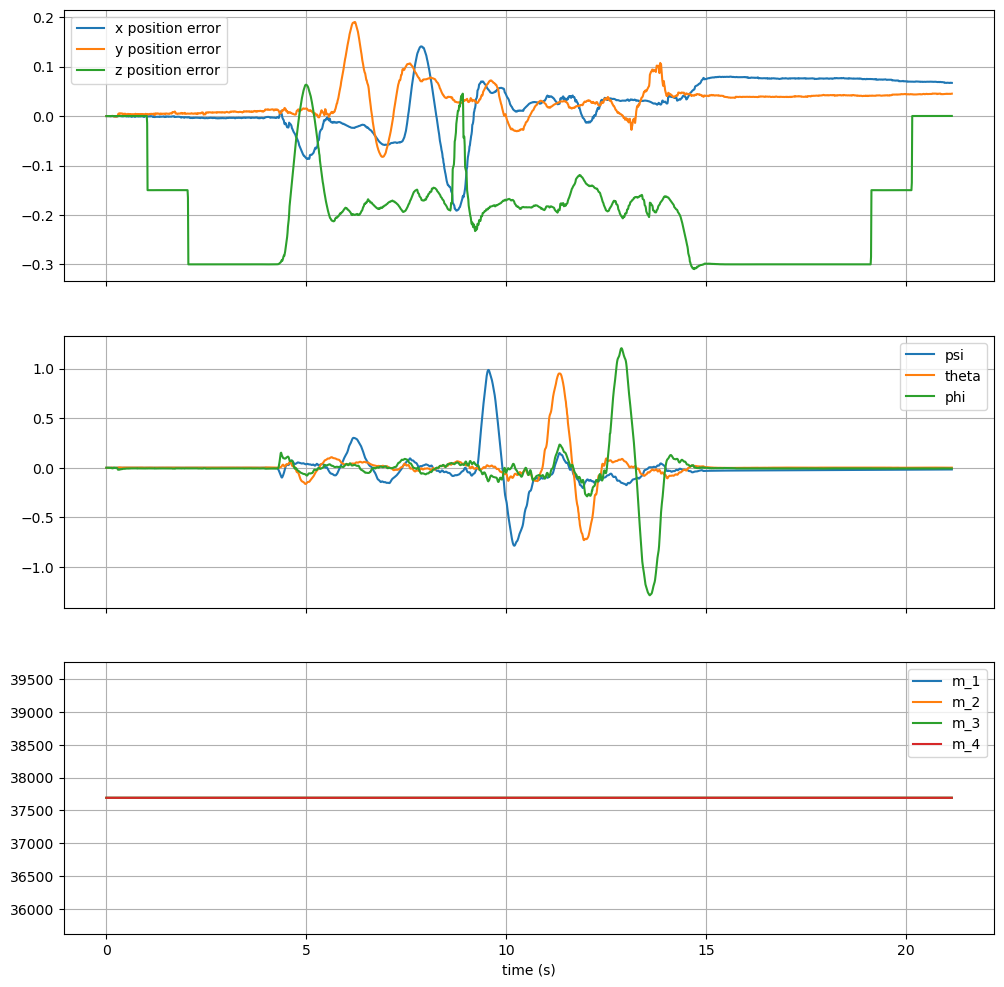

In [58]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

#### Discuss the flight test

Replace this cell with a description of your results. Note any differences between what you expected and what you saw, in particular trying to explain the cause of any failures (e.g., crashed drone). Say what might be done to further improve performance.

### 5.2.3 Hardware results

#### Describe the flight test

Replace this cell with the following information, at minimum:

* A description of the flight trajectory, both in words and (if you like) a snippet of code from `flight.py`.
* A description of the flight conditions (e.g., where was the flight conducted, did you power cycle the drone just before flying, were you using the positioning system or only the onboard sensors, etc.).

#### Show a video of the flight test

In the following cell, show a video of your hardware flight test (change the url as appropriate).

In [80]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/1_cq0n6lx2')

#### Plot results from the flight test

Load data from hardware.

In [59]:
data = load_hardware_data(
    'hardware_data.json', # <-- replace with name of file with hardware data
    t_min_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=0.,      # <-- (optional) replace with how many seconds of data to ignore at end
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [60]:
# time
t = data['time']

# position
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# orientation
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']

# motor power commands
m_1 = data['ae483log.m_1']
m_2 = data['ae483log.m_2']
m_3 = data['ae483log.m_3']
m_4 = data['ae483log.m_4']

Compute error in position (this is a function of time).

In [61]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

Text(0.5, 0, 'time (s)')

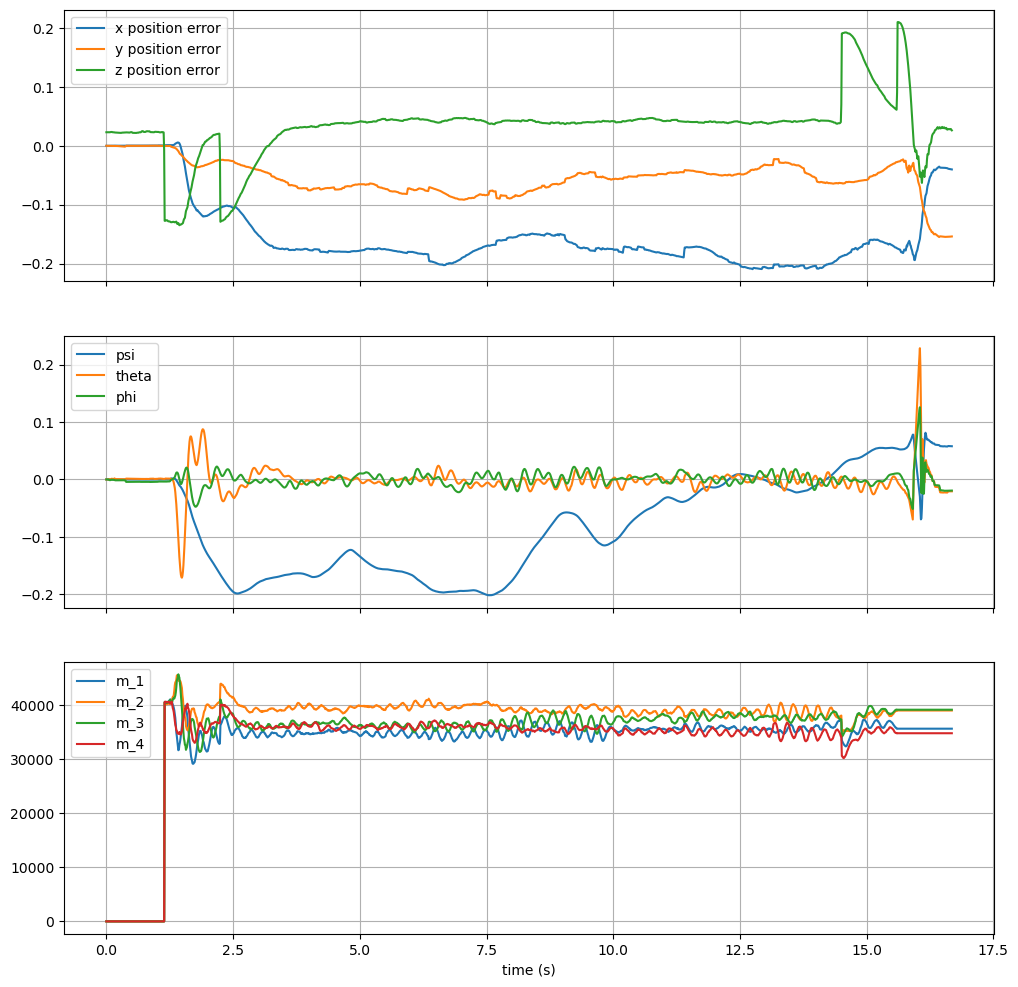

In [62]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

# 6. Summarize and discuss the results

**Modify the text in this cell** to answer the following questions:

* What level of performance were you able to achieve?
    - We were able to achieve errors for x, y, z, roll, pitch, and yaw to be within +/- 0.2. The controller made a smooth ascent, hover with a very slight drift, and landed with a smooth descent.
* What are the remaining limitations of your controller?
    - Big changes in desired position may cause large motor power commands, and drift as the drone wants to push to the location as fast as possible. A big limitation is that the sensors can vary the performance of the drone based on the ground pattern.
* How might the control architecture be changed to address these limitations or to further improve performance?
    - Optimize the Q and R matrices to have even lower errors with smooth movement to desired locations. 

# 7. Improving Controller Design

To get a working controller in hardware, you will likely need to repeat the following steps many times:

* Design a controller
* Implement and test this controller in simulation
* Implement and test this controller in hardware

Here is a template for these three steps. Please duplicate this template for each flight test. Please also modify this template as appropriate (e.g., doing more than one flight test with the same controller, or doing only hardware flight tests when fine-tuning performance after you get a working controller).

### 5.2.1 Control design

For your controller, we suggest you use linear state feedback of the form

$$u = - K (x - x_\text{des})$$

where the gain matrix $K$ is chosen by solving an infinite-horizon LQR problem (e.g., with the helper function `lqr`) and where

$$x_\text{des} = \begin{bmatrix} o_{x, \text{des}} \\ o_{y, \text{des}} \\ o_{z, \text{des}} \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}.$$

Remember that the LQR problem is defined by the choice of weights $Q$ and $R$. Both must be square matrices, $Q$ must be positive semidefinite, and $R$ must be positive definite. Both $Q$ and $R$ are almost always chosen to be diagonal. Remember that $Q$ penalizes non-zero states (i.e., non-zero values of $x$) and that $R$ penalizes non-zero inputs (i.e., non-zero values of $u$). If you want smaller states, increase $Q$. If you want smaller inputs, increase $R$.

**Replace this text** to say why and how you chose $Q$ and $R$ for the controller used in this flight test.

In [109]:
Q = np.diag([
    50.,
    20.,
    100.,
    200.,
    10.,
    10.,
    1.,
    1.,
    1.,
    1.,
    1.,
    1.,
])

R = 20 * np.diag([
    (1/(4*l*k_F * 6960.5))**2,
    (1/(4*l*k_F * 6960.5))**2,
    (1/(4*k_M * 6960.5))**2,
    (1/(4*k_F * 6960.5))**2,
])

Find $K$ for the chosen $Q$ and $R$.

In [110]:
K = lqr(A, B, Q, R)

Show $K$ (formatted nicely).

In [111]:
K_str = np.array2string(K,
                        formatter={'float_kind': lambda x: f'{x:6.3f}'},
                        prefix='    ',
                        max_line_width=np.inf)

print(f'K = {K_str}')

K = [[-0.000 -0.002  0.000 -0.000  0.000  0.004  0.000 -0.001  0.000  0.001  0.000 -0.000]
     [ 0.003 -0.000  0.000  0.000  0.004  0.000  0.002 -0.000  0.000  0.000  0.001 -0.000]
     [-0.000  0.000  0.000  0.001 -0.000 -0.000 -0.000  0.000  0.000 -0.000 -0.000  0.000]
     [ 0.000  0.000  0.126  0.000  0.000  0.000  0.000  0.000  0.090  0.000  0.000  0.000]]


Print code that implements the controller in python (for simulation).

In [112]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
)

tau_x = 0.00192165 * (o_y - o_y_des) -0.00390093 * phi + 0.00130879 * v_y -0.00054105 * w_x
tau_y = -0.00303840 * (o_x - o_x_des) -0.00443194 * theta -0.00171173 * v_x -0.00055448 * w_y
tau_z = -0.00079592 * psi -0.00021907 * w_z
f_z = -0.12638091 * (o_z - o_z_des) -0.08969888 * v_z + 0.30607200


Print code that implements the controller in C (for hardware).

In [113]:
export_controller(
    K,               # the gain matrix
    s,               # list of states as symbolic variables
    i,               # list of inputs as symbolic variables
    s_with_des,      # list of states that have desired values as symbolic variables
    i_eq,            # list of equilibrium values of inputs
    suffix='f',      # character to print after each number (indicates a "float")
    line_ending=';'  # character to print after each line
)

tau_x = 0.00192165f * (o_y - o_y_des) -0.00390093f * phi + 0.00130879f * v_y -0.00054105f * w_x;
tau_y = -0.00303840f * (o_x - o_x_des) -0.00443194f * theta -0.00171173f * v_x -0.00055448f * w_y;
tau_z = -0.00079592f * psi -0.00021907f * w_z;
f_z = -0.12638091f * (o_z - o_z_des) -0.08969888f * v_z + 0.30607200f;


Replace this cell with a description of your results. Note any differences between what you expected and what you saw, in particular trying to explain the cause of any failures (e.g., crashed drone). Say what might be done to further improve performance.

### 5.2.3 Hardware results

#### Describe the flight test

Replace this cell with the following information, at minimum:

* A description of the flight trajectory, both in words and (if you like) a snippet of code from `flight.py`.
* A description of the flight conditions (e.g., where was the flight conducted, did you power cycle the drone just before flying, were you using the positioning system or only the onboard sensors, etc.).

#### Show a video of the flight test

In the following cell, show a video of your hardware flight test (change the url as appropriate).

In [ ]:
# FIXME (REPLACE URL TO SHOW A VIDEO OF YOUR FLIGHT)
mediaspace('https://mediaspace.illinois.edu/media/t/1_cq0n6lx2')

#### Plot results from the flight test

Load data from hardware.

In [93]:
data = load_hardware_data(
    'hardware_data_20.json', # <-- replace with name of file with hardware data
    t_min_offset=1.5,      # <-- (optional) replace with how many seconds of data to ignore at start
    t_max_offset=2.5,      # <-- (optional) replace with how many seconds of data to ignore at end
)

Parse data to get:

* time
* position
* desired position
* orientation
* motor power commands

In [94]:
# time
t = data['time']

# position
o_x = data['ae483log.o_x']
o_y = data['ae483log.o_y']
o_z = data['ae483log.o_z']

# desired position
o_x_des = data['ae483log.o_x_des']
o_y_des = data['ae483log.o_y_des']
o_z_des = data['ae483log.o_z_des']

# orientation
psi = data['ae483log.psi']
theta = data['ae483log.theta']
phi = data['ae483log.phi']

# motor power commands
m_1 = data['ae483log.m_1']
m_2 = data['ae483log.m_2']
m_3 = data['ae483log.m_3']
m_4 = data['ae483log.m_4']

Compute error in position (this is a function of time).

In [95]:
o_x_err = o_x - o_x_des
o_y_err = o_y - o_y_des
o_z_err = o_z - o_z_des

Plot position error, orientation, and motor power commands.

Text(0.5, 0, 'time (s)')

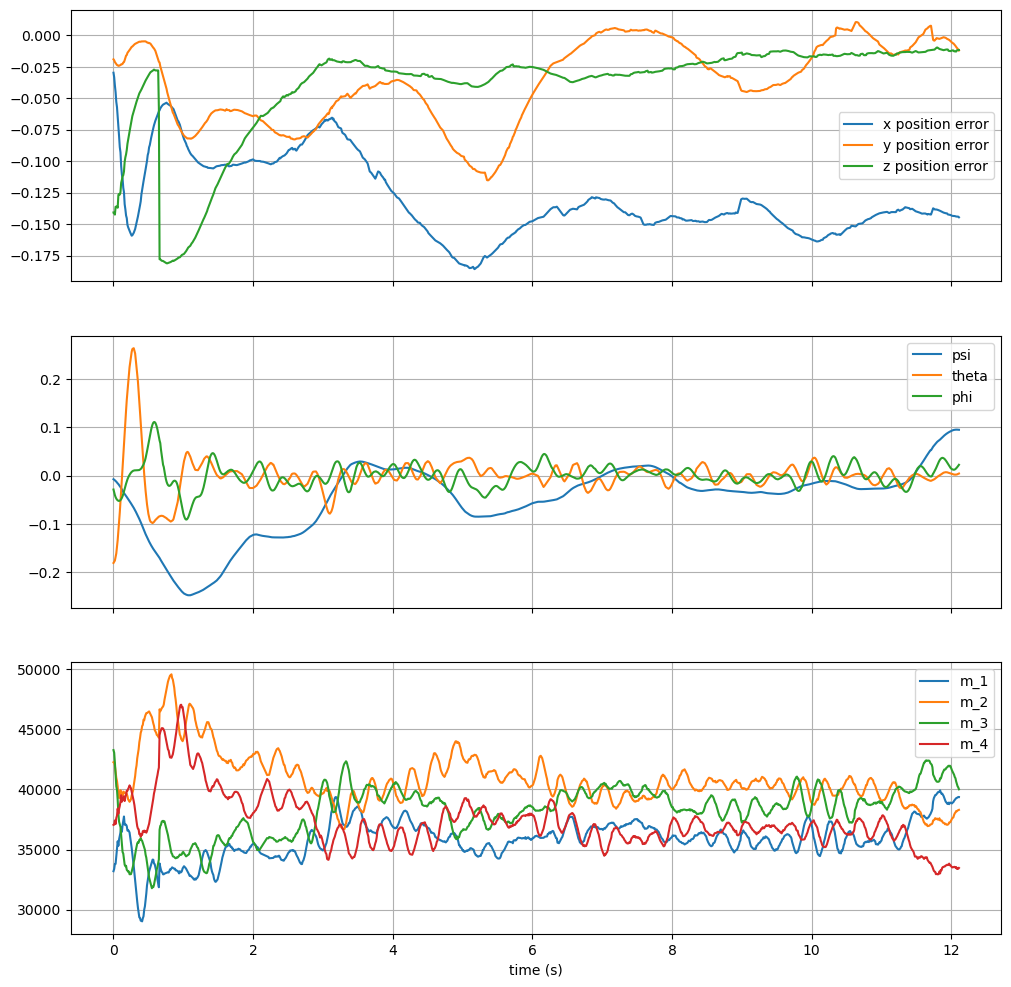

In [96]:
fig, (ax_pos, ax_ori, ax_pow) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
ax_pos.plot(t, o_x_err, label='x position error')
ax_pos.plot(t, o_y_err, label='y position error')
ax_pos.plot(t, o_z_err, label='z position error')
ax_pos.legend()
ax_pos.grid()
ax_ori.plot(t, psi, label='psi')
ax_ori.plot(t, theta, label='theta')
ax_ori.plot(t, phi, label='phi')
ax_ori.legend()
ax_ori.grid()
ax_pow.plot(t, m_1, label='m_1')
ax_pow.plot(t, m_2, label='m_2')
ax_pow.plot(t, m_3, label='m_3')
ax_pow.plot(t, m_4, label='m_4')
ax_pow.legend()
ax_pow.grid()
ax_pow.set_xlabel('time (s)')

In [97]:
o_x_rmse = np.sqrt(np.mean(o_x_err**2))
o_y_rmse = np.sqrt(np.mean(o_y_err**2))
o_z_rmse = np.sqrt(np.mean(o_z_err**2))
psi_rmse = np.sqrt(np.mean(psi**2))
theta_rmse = np.sqrt(np.mean(theta**2))
phi_rmse = np.sqrt(np.mean(phi**2))

print(o_x_rmse, o_y_rmse,o_z_rmse, psi_rmse,theta_rmse,phi_rmse )

0.13382025704380796 0.04925525549899008 0.05670389071539347 0.08674656217134251 0.03986154350748706 0.02402784757468483


| Flight Number | RMSE in $o_x$ | RMSE in $o_y$ | RMSE in $o_z$ | RMSE in $\psi$ | RMSE in $\theta$ | RMSE in $\phi$ | Key Changes |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :-- |
| Required | 0.075| 0.075| 0.075| 0.05| 0.015| 0.015| Required|
| 1 | 0.1631| 0.0617| 0.0617| 0.114| 0.0241| 0.0127| Increase Q on X,Y,Z|
| 2 |0.4263373972499815 |0.23245623715214736 |0.17547135057990718 |0.4081317473564306 |0.1531737400480561 |0.576133912828566|
| 5 | .03666008334811136 |0.03828967343456246 |0.051444956057468634 |0.35646856826513046 |0.03742286086536581 |0.02564151138749116|
|6|0.06358625968010855 |0.036309889435779154 |0.050983621124710096 |0.06888758887835228 |0.020985300674459764 |0.022362826901128872|
|9| 0.1625735298227319 |0.019797572787914584 |0.06267067838594301 |0.15718734191465195 |0.024829565055907502 |0.01727486158806944|
|10|0.06872589715036939 |0.013415573422574363 |0.036508585775450964 |0.06560305086920772 |0.025634211331317967 |0.016338400950692392|20, 20, 100, 100, 20, 20, 10|
|12| 0.10226459202367805 |0.050253126642898 |0.04273906979255163 |0.06334435746337155 |0.025187236265295895 |0.014125939013976602|20, 20, 100, 100, 20, 20, 20|
|13| 0.05773367638404272 |0.027269646235518422 |0.042785859549428235 |0.118001656235118 |0.023152153403760693 |0.013292268768185756|50, 20, 100, 100, 20, 20, 20|
|14|0.054364135039251936 |0.034584769689441984 |0.04383554409335946 |0.07891406040607543 |0.026710911907034438 |0.016277626956592| 50, 20, 100, 200, 20, 20, 20|
|19|.11520156122803059 |0.0805901899571809 |0.04347699668327549 |0.06201660674695524 |0.031432359665600006 |0.01290244977826989|   50, 20, 100, 200, 10, 20, 20|
